# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:100]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# Learning Rate Scheduler
- tf.keras.callbacks.LearningRateScheduler의 verbose=1이면 learning rate가 print됨

In [14]:
import math

In [15]:
def scheduler(epoch):
    if epoch < 10 : 
        return 0.001
    else :
        return 0.001 * math.exp(0.1*(10-epoch))

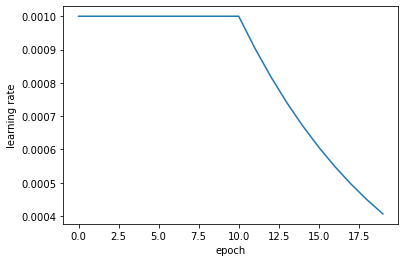

In [16]:
x = np.arange(0,20)
y = 0.001 * np.exp(0.1*(10-x))
y[:10] = 0.001

plt.ylabel("learning rate")
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [17]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

## Training

In [18]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[learning_rate_scheduler]
)

C:\Users\jumin\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
31/31 [==============================] - 7s 154ms/step - loss: 2.3021 - accuracy: 0.1064 - val_loss: 2.2944 - val_accuracy: 0.0625
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
31/31 [==============================] - 5s 153ms/step - loss: 2.2324 - accuracy: 0.1591 - val_loss: 2.1623 - val_accuracy: 0.2188
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
31/31 [==============================] - 5s 149ms/step - loss: 2.1342 - accuracy: 0.2045 - val_loss: 2.0931 - val_accuracy: 0.1771
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
31/31 [==============================] - 5s 167ms/step - loss: 2.0964 - accuracy: 0.1860 - val_loss: 2.0591 - val_accuracy: 0.2812
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
31/31 [==============================] - 5s 159ms/step - loss: 2.0058 - accu